In [1]:
import sys
sys.path.append("../")  # look one directory up for qca modules, TODO: make a package
from copy import copy
import os
from qca import QCA
from states import make_state
from mpl_toolkits import mplot3d
from matplotlib import cm
from scipy.optimize import curve_fit
from os import makedirs
import matplotlib.pyplot as plt
import measures as ms
import numpy as np
%matplotlib inline
der=r"/home/lhillber/documents/research/cellular_automata/qeca/qca/data/"

In [2]:
import qca
import core
import measures
from importlib import reload
reload(qca)
reload(core)
reload(measures)
from qca import QCA

In [38]:
Rsbisects = []
RnetCs = []
RnetDs = []
RnetYs = []
RLs = [7, 8, 9, 10, 11, 12, 13, 14, 15]
for L in RLs:
    # incoherent random state
    #state = make_state(L, "P")
    
    state = np.exp(2 * np.pi *1j * np.random.uniform(0, 1, 2**L))
    state /=  np.sqrt(np.conj(state).dot(state)).real
    
    state = make_state(L, "P")

    #state = np.exp(1j*np.random.uniform(0,2*np.pi, 2**L))
    #state /=  np.sqrt(np.conj(state).dot(state)).real
    
    # compute density matricies
    rhoj = ms.get_rhoj(state)
    rhojk = ms.get_rhojk(state)
    bisect = ms.get_bisect(state)

    # compute intermediate measures
    s1 = ms.get_entropy(rhoj, order=1)
    s2 = ms.get_entropy2(rhojk, order=1)
    M = ms.get_MI(s1, s2)
    
    # compute measures and append to list
    Rsbisects.append(ms.renyi_entropy(bisect, order=1))
    RnetCs.append(ms.network_clustering(M))
    RnetDs.append(ms.network_density(M))
    RnetYs.append(ms.network_disparity(M))
    print(L, ms.network_clustering(M))
# lists to numpy arrays
Rsbisect = np.array(Rsbisects)
RnetCs = np.array(RnetCs)
RnetDs =np.array(RnetDs)
RnetYs = np.array(RnetYs)

7 0.024609581013229947
8 0.013501793255807894
9 0.007191496682412471
10 0.0032477766578322027
11 0.0015835436998661292
12 0.0008387646577722058
13 0.00036412653659077706
14 0.00019242087538175298
15 9.922855326878675e-05


In [39]:
def exponential(t, t0, A, B, T):
    return A* np.exp(-(t-T)/t0) + B

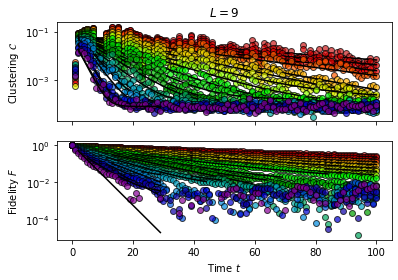

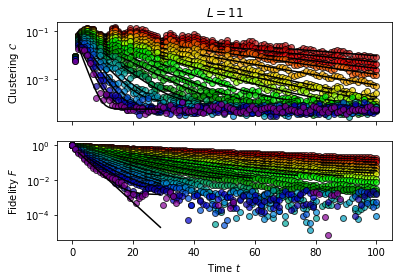

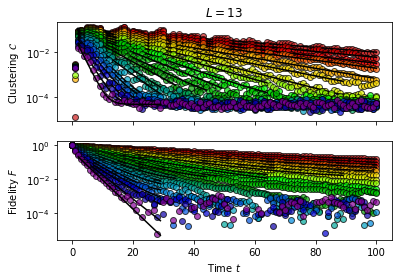

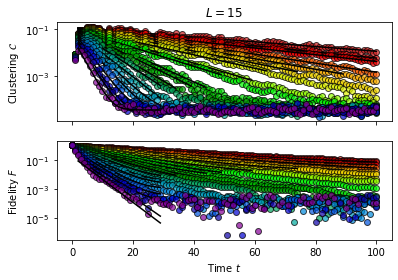

In [64]:
N = 500

tmax=60

Es = np.array(
      [0.0033, 0.0039, 0.0047, 0.0057, 
       0.0068, 0.0081, 0.0097, 0.0116, 
       0.0139, 0.0166, 0.0199, 0.0238, 
       0.0285, 0.0341, 0.0408, 0.0488, 
       0.0584, 0.0699, 0.0836, 0.1])


Ls = np.array([9, 11, 13, 15]) # system size

# Parameters template
params_template = dict(L=15,
              T=100.0,
              dt=1.0,
              R=6,
              r=1,
              V="H",
              BC="1-00",
              IC="c1_f0",
              E=0.0,
              N=N,
              totalistic=False,
              hamiltonian=False,
              trotter=True,
              symmetric=False)


# place store parameters
popts_C = np.zeros((len(Ls), len(Es), 4))
perrs_C = np.zeros((len(Ls), len(Es), 4))
popts_F = np.zeros((len(Ls), len(Es), 4))
perrs_F = np.zeros((len(Ls), len(Es), 4))
t0s = np.zeros((len(Ls), len(Es)))

cmap = cm.get_cmap("nipy_spectral_r")
cs = [cmap((j+1) * (0.9)/(len(Es))) for j in range(len(Es))]

Qs = np.zeros((len(Ls), len(Es)), dtype="object")

for i, L in enumerate(Ls):
    fig, axs = plt.subplots(2, 1, sharex=True)
    params = copy(params_template)
    params["L"] = L
    params.update({"E": 0.0, "N": 1})
    Q0 = QCA(params)

    for j, (E, c) in enumerate(zip(Es, cs)):
        params.update({"E": E, "N":N})
        # run sims
        Q = QCA(params, der=der)
        Q.close()
        Q = QCA(params, der=der)
        #Q.run(tasks=["rhoj", "rhojk"], verbose=False)
        Qs[i, j] = Q
        for trial in range(2):
            if trial == 0:
                tM = tmax
            else:
                tM = 5 * max(int(popt_F[0]), 6)
            tm=2
            CFs = Q.C(1)[tm:tM]
            ts = Q.ts[tm:tM]
            Fs = Q.F(save=True)[tm:tM]
            mask = CFs>0

            popt_F, pcov_F = curve_fit(exponential, ts, Fs, 
                                       p0=[1, np.max(Fs), np.abs(Fs[-1]),0], 
                                       sigma=Fs, 
                                       bounds=([0,0,0,0],[np.inf, np.inf, np.inf, 1e-6]))
            popt_C, pcov_C = curve_fit(exponential, ts[mask], CFs[mask],
                                       p0=[1, np.max(CFs)/10, np.abs(CFs[-1]),np.argmax(CFs)], 
                                       sigma=CFs[mask], 
                                       bounds=([0,0,0,0],[np.inf, np.inf, np.inf, np.inf]))
      
        if Q.L == 15 and Q.E==0.0199:
            Q2 = Q
            popt_C2 = popt_C
        Q.close()
        # standard error of fit parameter
        perr_C = np.sqrt(np.diag(pcov_C))
        perr_F = np.sqrt(np.diag(pcov_F))
       
        # record parameters
        popts_C[i, j, :] = popt_C
        perrs_C[i, j, :] = perr_C
                
        popts_F[i, j, :] = popt_F
        perrs_F[i, j, :] = perr_F
       
        #axs[0].plot(
        #    ts, Cs, marker="o", mec="k", mfc=c, ls="none")
        axs[0].plot(Q.ts[1:], Q.C(1)[1:], marker="o", mec="k", mfc=c, ls="none", alpha=0.7)
        axs[0].plot(ts, exponential(ts, *popt_C),c="k")
        axs[0].set_ylabel(r"Clustering $\mathcal{C}$")
        axs[1].set_ylabel(r"Fidelity $F$")
        axs[0].set_title(f"$L={L}$")
       
        
        axs[1].set_xlabel(r"Time $t$")
        axs[1].plot(Q.ts, Q.F(), marker="o", mec="k", mfc=c, ls="none", alpha=0.7)
        axs[1].plot(ts, exponential(ts, *popt_F),c="k")
   
        
    
        Q.close()
    # plot E=0 reference 
   #axs[0].plot(
   #         Q0.ts[2:], Q0.C(2)[2:], marker="o", mfc="none", c="crimson")
    axs[0].set_yscale("log")
    axs[1].set_yscale("log")

    
    #axs[0].axhline(RnetCs[RLs.index(Q.L)], c="k")
    
    #params = copy(params_template)
    #params.update({"L":Q.L, "E": 0, "N": 500,"E": 0.02/3, "IC": "P123"})
    #Q1 = QCA(params, der=der)
    # plot Porter-Thomas
    #ax.plot(
    #        Q0.ts[1:], Q0.C(1)[1:], marker="o", mfc="none", c="k")
    
    #axs[0].text(0.02,0.065,"Porter-\nThomas\n pure state",transform=ax.transAxes)
    fig.savefig(f"figures/C-fits_L{Q.L}_R{Q.R}_N{N}_depolarized.pdf", bbox_inches="tight")
    plt.show()

In [47]:
Cbars = np.array([np.mean(Qs[i, -1].C_1[-20:]) for i in range(len(Ls))])

AttributeError: module 'matplotlib.pyplot' has no attribute 'scale'

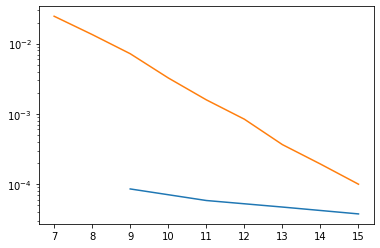

In [52]:
plt.plot(Ls, Cbars)
plt.plot(RLs, RnetCs)
plt.yscale("log")
plt.scale("log")

<AxesSubplot:xlabel='Site $j$', ylabel='Time $t$'>

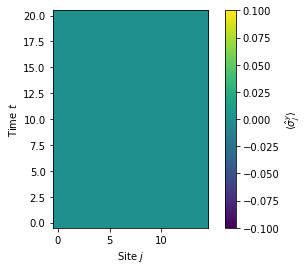

In [70]:
Qs[-1,-1].plot("exp_Y", tmax=20)

In [50]:
Qs.shape

(4, 20)

In [7]:
print(np.array(
      [0.0033, 0.0039, 0.0047, 0.0057, 
       0.0068, 0.0081, 0.0097, 0.0116, 
       0.0139, 0.0166, 0.0199, 0.0238, 
       0.0285, 0.0341, 0.0408, 0.0488, 
       0.0584, 0.0699, 0.0836, 0.1]))

[0.0033 0.0039 0.0047 0.0057 0.0068 0.0081 0.0097 0.0116 0.0139 0.0166
 0.0199 0.0238 0.0285 0.0341 0.0408 0.0488 0.0584 0.0699 0.0836 0.1   ]


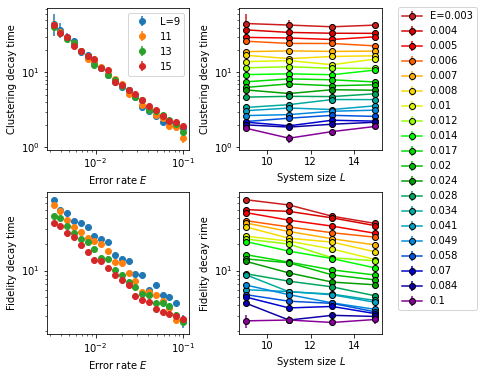

In [8]:
fig, axs = plt.subplots(2,2, figsize=(6,6))
for row, (popts, perrs) in enumerate(zip([popts_C, popts_F], [perrs_C, perrs_F])):
    
    # Plot decay time vs error rate for all system sizes
    for i, L in enumerate(Ls):
        if i==0:
            label=f"L={L}"
        else:
            label=L
        axs[row, 0].errorbar(Es, popts[i,:,0],
                        yerr=perrs[i,:,0],
                        label=label, 
                        marker="o",
                       ls="none")

    # plot decay time vs system size for all error rates
    for j, (E, c) in enumerate(zip(Es, cs)):
        E=round(E,3)
        if j==0:
            label=f"E={E}"
        else:
            label=E
        axs[row, 1].errorbar(Ls, popts[:,j,0], 
                        yerr=perrs[:,j,0], 
                        label=label,
                        c=c,
                        mec="k",
                        marker="o")

    # fit power law of decay time vs error rate to largest L data
    x, y = Es, popts[i,:,0]
    m,b = np.polyfit(np.log10(x), np.log10(y), deg=1)
    def powerlaw(x):
        return 10**b * x ** m
    #axs[0].plot(x, powerlaw(x), c="k", zorder=100)
    #axs[0].text(0.5, 0.6, f"slope: {round(m,2)}", transform=axs[0].transAxes)

    # scales and labels
    axs[row, 0].set_yscale("log")
    axs[row, 0].set_xscale("log")
    axs[row, 1].set_yscale("log")
axs[0, 0].set_ylabel(r"Clustering decay time")
axs[1, 0].set_ylabel(r"Fidelity decay time")
axs[0, 1].set_ylabel(r"Clustering decay time")
axs[1, 1].set_ylabel(r"Fidelity decay rime")
axs[1, 0].set_xlabel("Error rate $E$") 
axs[1, 1].set_xlabel("System size $L$")
axs[0, 0].set_xlabel("Error rate $E$") 
axs[0, 1].set_xlabel("System size $L$")
axs[0, 0].legend(loc="upper right")
axs[0, 1].legend(loc="upper right", bbox_to_anchor=[1.7,1.04], ncol=1)

plt.subplots_adjust(hspace=0.3, wspace=0.35)

# save figure
#fig.savefig(f"figures/F-C_decay_time_vs_E-L.pdf", bbox_inches="tight")

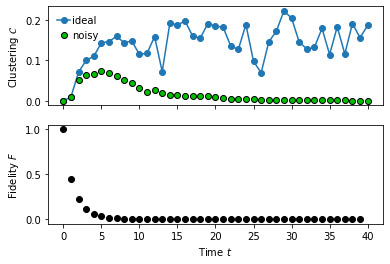

In [9]:
fig, (ax0, ax1)= plt.subplots(2,1, sharex=True)
Q0.plot("C_1", ax=ax0, tmax=40, marker="o",  label="ideal")
Qs[-1,10].plot("C_1", ax=ax0, tmax=40, marker="o", label="noisy", mec="k", mfc=cs[10], ls="none")
ax0.set_ylabel("Clustering $\mathcal{C}$")
ax0.legend(loc="upper left", frameon=False, handletextpad=0.2, handlelength=1.3)
ax0.set_xlabel("")
ax1.plot(Q.F()[:40], c="k", marker="o", ls="none")
ax1.set_ylabel("Fidelity $F$")
ax1.set_xlabel("Time $t$")
plt.savefig("figures/C_and_F_example_E2-percent.pdf")

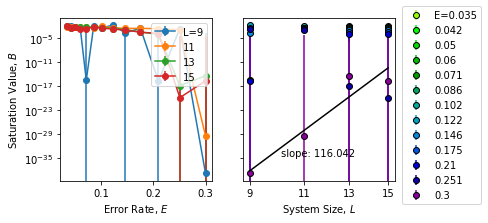

In [10]:
fig, axs = plt.subplots(1,2, figsize=(6,3), sharey=True)
mindex=7

# Plot saturation value vs error rate for all system sizes
for i, L in enumerate(Ls):
    if i==0:
        label=f"L={L}"
    else:
        label=L
    axs[0].errorbar(Es[mindex:]*3, popts[i,mindex:,2],
                    yerr=perrs[i,mindex:,2],
                    label=label, 
                    marker="o")
    
# plot saturation value vs system size for all error rates
for j, (E, c) in enumerate(zip(Es[mindex:], cs[mindex:])):
    j+=mindex
    E=round(E*3,3)
    if j==mindex:
        label=f"E={E}"
    else:
        label=E
    axs[1].errorbar(Ls, popts[:,j,2], 
                    yerr=perrs[:,j,2], 
                    label=label,
                    ls="none",
                    c=c,
                    mec="k",
                    ecolor=c,
                    marker="o")


# fit power law of saturation value vs system size for largest error rate
x, y = Ls, popts[:,j,2]
m,b = np.polyfit(np.log10(x), np.log10(y), deg=1)
def powerlaw(x):
    return 10**b * x ** m
axs[1].plot(x, powerlaw(x), c="k",zorder=100)
axs[1].text(0.25, 0.15, f"slope: {round(m,3)}", transform=axs[1].transAxes)

# scales and labels
axs[0].set_yscale("log")
axs[1].set_xscale("log")
axs[1].set_xticks(Ls)
axs[1].set_xticklabels(Ls)
axs[1].minorticks_off()

axs[0].set_ylabel(r"Saturation Value, $B$")
axs[0].set_xlabel("Error Rate, $E$")
axs[0].legend(loc="upper right")
axs[1].set_xlabel("System Size, $L$")
axs[1].legend(loc="upper right", bbox_to_anchor=[1.6,1.1])

# save figure
#fig.savefig(f"figures/sat-val_vs_E-L.pdf", bbox_inches="tight")

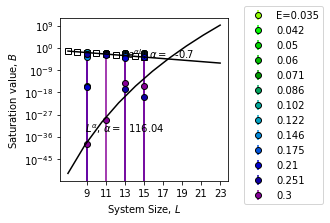

In [11]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
mindex=7
x2 = np.linspace(7,23,10)
    
# plot saturation value vs system size for all error rates
for j, (E, c) in enumerate(zip(Es[mindex:], cs[mindex:])):
    j+=mindex
    E=round(E*3,3)
    if j==mindex:
        label=f"E={E}"
    else:
        label=E
    ax.errorbar(Ls, popts[:,j,2], 
                    yerr=perrs[:,j,2], 
                    label=label,
                    ls="none",
                    c=c,
                    mec="k",
                    ecolor=c,
                    marker="o")


# fit power law of saturation value vs system size for largest error rate
x, y = Ls, popts[:,j,2]
m,b = np.polyfit(np.log10(x), np.log10(y), deg=1)
def powerlaw(x):
    return 10**b * x ** m
ax.plot(x2, powerlaw(x2), c="k",zorder=100)
ax.text(0.15, 0.3,  r"$L^{\alpha},\,\alpha=$  %s"%round(m,2), transform=ax.transAxes)


# Porter Thomas random state scaling
x, y = RLs, RnetCs
m,b = np.polyfit(x, np.log(y), deg=1)
def explaw(x):
    return np.exp(b  +m *x)
ax.plot(x2, explaw(x2), c="k",zorder=100)
ax.plot(x, y, mec="k", marker="s", mfc="none", ls="none")
ax.text(0.4, 0.75, r"$e^{\alpha L},\,\alpha=$  %s"%round(m,2), transform=ax.transAxes)




# scales and labels
ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xticks(np.hstack((Ls , [17, 19, 21, 23])))
ax.set_xticklabels(np.hstack((Ls , [17, 19, 21, 23])))
ax.minorticks_off()

ax.set_ylabel(r"Saturation value, $B$")
ax.set_xlabel("System Size, $L$")
ax.legend(loc="upper right", bbox_to_anchor=[1.6,1.1])

# save figure
#fig.savefig(f"figures/PT-random_R6-sat-val_vs_L.pdf", bbox_inches="tight")

## Experiment compare

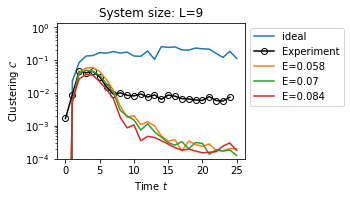

In [12]:
fig, ax = plt.subplots(1,1, figsize=(3.375, 2.5))
experiment_Ls = [5, 7, 9]
tmax=25

experiment_der = os.path.join(der,"experiment_data")
Ce_avg = 0
for L in experiment_Ls:
    name= f'{L}_exp_clustering_and_disparity_RC_FalsePS_False.npz'
    fname = os.path.join(experiment_der, name)
    Ce = np.load(fname)
    Ce = Ce['arr_1']
    #Ce -= Ce[0]
    Ce_avg += Ce/len(experiment_Ls)
    
Q0.plot("C_2", ax=ax, tmax=tmax, label="ideal")
ax.plot(Ce[:tmax], marker="o", c="k", mec="k", mfc="none", label="Experiment")
for j in (16,17,18):
    Qs[0,j].plot("C_2", ax=ax, tmax=tmax, label=f"E={round(Es[j],3)}")
ax.set_ylabel("Clustering $\mathcal{C}$")
ax.set_yscale("log")
ax.set_ylim(bottom=1e-4)
ax.set_title("System size: L=9")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.savefig("figures/clustering-order2_experiment-compare.pdf", bbox_inches="tight")

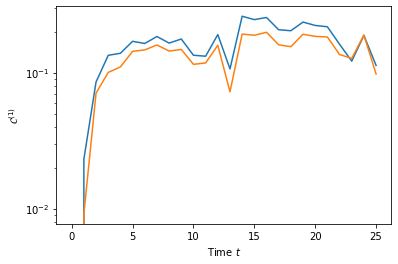

In [13]:
ax=Q0.plot("C_2", tmax=25)
Q0.plot("C_1", ax=ax, tmax=25)
ax.set_yscale("log")

In [14]:
reload(measures)
reload(qca)
from qca import QCA
from measures import network_clustering

In [15]:
params_template = dict(
              L=2,
              T=1.0,
              dt=1.0,
              R=6,
              r=1,
              V="I",
              BC="1-00",
              IC="B0-1_2",
              E=0.0,
              N=N,
              totalistic=False,
              hamiltonian=False,
              trotter=True,
              symmetric=False)

params = copy(params_template)
Q0 = QCA(params)
Q0.run(tasks=["rhoj", "rhojk"])


28 January 2021, 15:18:18
Nothing to add to 98f73b2df4221515babfb950e7ee534f4dc734cf
Parameters: {'L': 2, 'T': 1.0, 'dt': 1.0, 'R': 6, 'r': 1, 'V': 'I', 'IC': 'B0-1_2', 'BC': '1-00', 'E': 0.0, 'N': 500, 'trotter': True, 'symmetric': False, 'totalistic': False, 'hamiltonian': False}
Available data: ['params', 'rhoj', 'rhojk']
Total file size: 0.01 MB
Took: 0.00 s
Data at:
/home/lhillber/documents/research/cellular_automata/qeca/qca/data/98f73b2df4221515babfb950e7ee534f4dc734cf.hdf5



In [33]:
L=11
# Parameters template
params_template = dict(L=L,
              T=100.0,
              dt=1.0,
              R=6,
              r=1,
              V="H",
              BC="1-00",
              IC="c1_f0",
              E=0.0,
              N=N,
              totalistic=False,
              hamiltonian=False,
              trotter=True,
              symmetric=False)
params = copy(params_template)
params["L"] = L
params.update({"E": 0.0, "N": 1})
Q0 = QCA(params)

In [34]:
p00s = Q0.exp2("00")
p01s = Q0.exp2("01")
p10s = Q0.exp2("10")
p11s = Q0.exp2("11")
p0s = Q0.exp("0")
p1s = Q0.exp("1")

As = []

print(np.min(p00s+p01s+p10s+p11s))

for p0, p1, p00, p01, p10, p11 in zip(p0s, p1s, p00s, p01s, p10s, p11s):
    pm = np.array([p0, p1])
    pmn = np.array([[p00, p01],[p10, p11]])
    A = np.zeros((Q0.L, Q0.L))
    for j in range(Q0.L):
        for k in range(Q0.L):
            if j != k:
                for m in (0, 1):
                    for n in (0, 1):
                        numerator = pmn[m, n, j, k]
                        denom = pm[m, j] * pm[n, k]
                        if denom > 0 and numerator > 0:
                            val = numerator*np.log2(numerator/denom)
                            A[j,k] += val
    As.append(A)
As = np.array(As)
            


0.0


In [35]:
import measures
reload(measures)
from measures import symm_mat_from_vec

In [36]:
experiment_der = os.path.join(der,"experiment_data")
name= f'clustering_and_disparity_RC_FalsePS_True.npz'
fname = os.path.join(experiment_der, name)
Cericf = np.load(fname)
Ceric = Cericf["arr_1"]

In [37]:
experiment_der = os.path.join(der,"experiment_data")
name= f'clustering_and_disparity_g2.npz'
fname = os.path.join(experiment_der, name)
Cericf = np.load(fname)
Cericg2 = Cericf["arr_1"]

In [38]:
Cs = [network_clustering(A) for A in As]
C_g2 = [network_clustering(g) for g in Q0.g2("ZZ")]
C_vNe2x = [network_clustering(M) for M in 2*Q0.MI(1)]

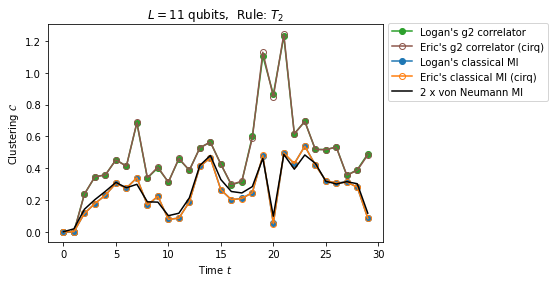

In [39]:
tmax=30
fig, ax = plt.subplots(1,1)

ax.plot(C_g2[:tmax], marker="o", c="C2", label="Logan's g2 correlator")
ax.plot(Cericg2[:tmax], c="C5", marker="o", label="Eric's g2 correlator (cirq)", mfc="none")

ax.plot(Cs[:tmax], marker="o",c="C0", label="Logan's classical MI")
ax.plot(Ceric, marker="o", c="C1", label="Eric's classical MI (cirq)", mfc="none")

ax.plot(C_vNe2x[:tmax], c="k", label="2 x von Neumann MI")

ax.set_ylabel("Clustering $\mathcal{C}$")
ax.set_xlabel("Time $t$")
ax.set_title(r"$L=11$ qubits,  Rule: $T_2$")
plt.legend(loc="upper left", bbox_to_anchor=(1,1.03))
#ax.set_ylim(bottom=0, top=3)
#ax.set_yscale("log")
#ax.set_ylim(bottom=1e-3)
plt.savefig("figures/T2_different_adjacency_matrices.pdf", bbox_inches="tight")



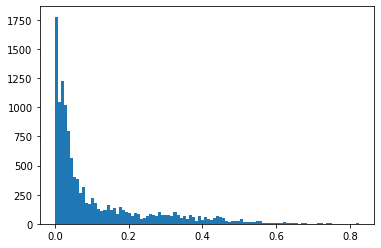

In [32]:
N = Q0.L * Q0.L*Q0.ts.size
plt.hist(np.ravel(2*Q0.MI(1)-Q0.g2("XX")**2 / 2 / (1*1)), bins=100);

In [24]:
from matrix import dagger, ops
from scipy.linalg import sqrtm

In [370]:
np.trace(sqrtm(ops["Z"].dot(dagger(ops["Z"]))))

(2+0j)

In [379]:
ops["Z"].dot(dagger(ops["Z"]))

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

In [626]:
O = ops["Y"]
np.trace(sqrtm(O.dot(np.conj(np.transpose(O)))))**2

(4+0j)

In [629]:
Oa = "X"
Ob = "X"
for t in Q0.ts:
    t=int(t)
    for j in range(Q0.L):
        for k in range(Q0.L):
            if j != k:
                v = Q0.MI(1)[t, j,k] - Q0.g2(Oa+Ob)[t,j,k]**2/2/16
                if v < 0:
                    print(v, (t, j, k))

In [466]:
from matrix import listkron, ops
from core1d import evolve
from measures import expectation
from states import bvecs

L=10
O = 0
for i in range(L+1):
    o = ["I"]*(L+2)
    o[i] = "Z"
    o[(i+1)]="Z"
    O += listkron(ops[k] for k in o)


In [468]:
gen = evolve(L, 20, 1, 6, 1, "H", "c3_f1", "1-01")

5.0
4.999999999999997
4.999999999999993
4.99999999999999
4.999999999999987
4.999999999999984
4.9999999999999805
4.999999999999975
4.999999999999973
4.999999999999969
4.9999999999999645
4.999999999999963
4.999999999999959
4.999999999999956
4.999999999999952
4.9999999999999485
4.999999999999943
4.999999999999939
4.999999999999937
4.9999999999999325
4.999999999999927
4.359103229624633e-15


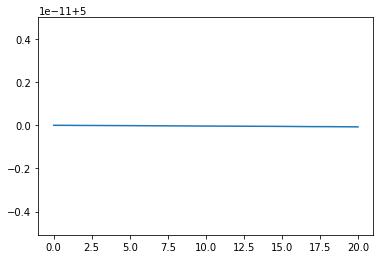

In [469]:
es = []
for s in gen:
    s = listkron([bvecs["0"], s, bvecs["1"]])
    e = expectation(s, O)
    print(e)
    es.append(e)
plt.plot(es)
print(np.std(es)/np.mean(es))